In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import re
import time
import argparse

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

/kaggle/input/crohme-data-basic/filtered_basic_arithmetic/train/images/expr_009203.png


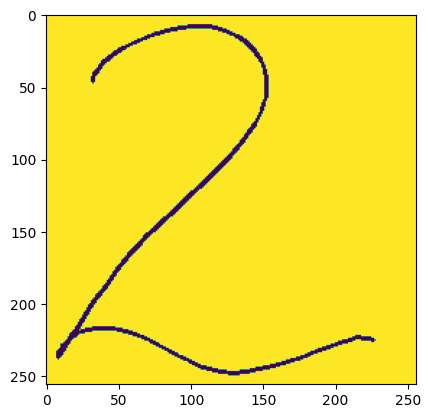

In [3]:
train_path = "/kaggle/input/crohme-data-basic/filtered_basic_arithmetic/train"
img_path = train_path+"/images/expr_"+"009203.png"
print(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [4]:
train_path = "/kaggle/input/crohme-data/val"
#print(os.path.join(train_path,"labels"))
count = 0
for files in os.listdir(os.path.join(train_path,"labels"))[:10]:
    #print(files)
    label_path = train_path+"/labels/"+files
    count+=1
    #print(label_path)
    f = open(label_path, 'r')
    print(f.read())
print(count)

{ 1 \mbox { u } }
$77 + 113 \geq 189$
x_x^x + y_y^y + z_z^z - x - y - z
\log \Delta
\left [ { P } _ { \mbox { I } } \right ]
{ \sigma = 6 }
$j^2 = +1$
$5 / (37 + 36 + 8) = 0.06$
$\frac{a}{\sin A} = \frac{b}{\sin B} = \frac{c}{\sin C}$
3 0 \times 2 9 x^{2 8}
10


In [5]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
# Configuration
class Config:
    def __init__(self):
        # Dataset paths
        self.data_root = '/kaggle/input/crohme-data'
        
        # Model parameters
        self.embed_dim = 256
        self.hidden_dim = 512
        self.num_layers = 1
        self.dropout = 0.3
        self.max_seq_len = 150
        
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 10
        self.learning_rate = 0.001
        self.teacher_forcing_ratio = 0.9
        self.teacher_forcing_decay = 0.9
        self.grad_clip = 5.0
        
        # Tokenizer parameters
        self.special_tokens = {
            'PAD': '<PAD>',
            'START': '<START>',
            'END': '<END>',
            'UNK': '<UNK>'
        }
        
        # Image preprocessing
        self.img_height = 128
        self.img_width = 512
        
        # Checkpoint parameters
        self.checkpoint_dir = 'checkpoints'
        self.log_dir = 'logs'
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Tokenizer for LaTeX expressions
class LaTeXTokenizer:
    def __init__(self, config):
        self.config = config
        self.token2idx = {}
        self.idx2token = {}
        self.build_vocab([])  # Initialize with special tokens
        
    def build_vocab(self, latex_expressions):
        # Add special tokens
        vocab = [self.config.special_tokens[token] for token in ['PAD', 'START', 'END', 'UNK']]
        
        # Add all unique tokens from latex expressions
        all_tokens = []
        for expr in latex_expressions:
            tokens = self._tokenize(expr)
            all_tokens.extend(tokens)
        
        # Count token frequencies
        token_counter = Counter(all_tokens)
        tokens = [token for token, _ in token_counter.most_common()]
        
        # Add tokens to vocabulary that aren't already special tokens
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
        
        # Create mappings
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for idx, token in enumerate(vocab)}
        
        return self
    
    def _tokenize(self, latex_str):
        """
        Tokenize a LaTeX string.
        This is a simplified approach - in a production system, you might need 
        more sophisticated tokenization based on LaTeX syntax.
        """
        # Remove extra whitespace
        latex_str = latex_str.strip()
        
        # Handle special LaTeX commands
        pattern = r'(\\[a-zA-Z]+|[^a-zA-Z0-9\s])'
        
        # Split by the pattern but keep the delimiters
        parts = re.split(f'({pattern})', latex_str)
        
        # Filter out empty strings and strip whitespace
        tokens = [part.strip() for part in parts if part.strip()]
        
        return tokens
    
    def encode(self, latex_str):
        """Convert LaTeX string to token IDs"""
        tokens = self._tokenize(latex_str)
        
        # Add START and END tokens
        tokens = [self.config.special_tokens['START']] + tokens + [self.config.special_tokens['END']]
        
        # Convert to indices, using UNK for unknown tokens
        unk_idx = self.token2idx[self.config.special_tokens['UNK']]
        indices = [self.token2idx.get(token, unk_idx) for token in tokens]
        
        return indices
    
    def decode(self, indices):
        """Convert token IDs back to LaTeX string"""
        # Convert indices to tokens
        start_idx = self.token2idx[self.config.special_tokens['START']]
        end_idx = self.token2idx[self.config.special_tokens['END']]
        pad_idx = self.token2idx[self.config.special_tokens['PAD']]
        
        # Filter out special tokens
        tokens = []
        for idx in indices:
            if idx == end_idx:  # Stop at END token
                break
            if idx not in [start_idx, pad_idx]:  # Skip START and PAD tokens
                tokens.append(self.idx2token[idx])
        
        # Join tokens (with space between symbols for readability)
        latex = ' '.join(tokens)
        
        # Clean up spaces around certain symbols
        latex = re.sub(r'\s+', ' ', latex)  # Replace multiple spaces with single space
        for symbol in ['+', '-', '=', '>', '<', '\\leq', '\\geq']:
            latex = latex.replace(f' {symbol} ', f' {symbol} ')
        
        return latex.strip()
    
    @property
    def vocab_size(self):
        return len(self.token2idx)

In [8]:
# Dataset class for CROHME
class CROHMEDataset(Dataset):
    def __init__(self, data_dir, tokenizer, config, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.tokenizer = tokenizer
        self.config = config
        self.transform = transform if transform else self._get_default_transform()
        
        # Get all image paths
        split_dir = os.path.join(data_dir, split)
        self.image_paths = sorted(glob.glob(os.path.join(split_dir, 'images', '*.png')))
        
        # Load all LaTeX expressions
        self.latex_expressions = []
        for img_path in self.image_paths:
            # Get corresponding label path
            file_id = os.path.basename(img_path).split('.')[0]
            label_path = os.path.join(split_dir, 'labels', f"{file_id}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r', encoding='utf-8') as f:
                    latex = f.read().strip()
                self.latex_expressions.append(latex)
            else:
                print(f"Warning: Label not found for {img_path}")
                self.latex_expressions.append("")  # Empty placeholder
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and transform image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        # Get and encode LaTeX
        latex = self.latex_expressions[idx]
        encoded_latex = self.tokenizer.encode(latex)
        
        # Pad sequence if needed
        if len(encoded_latex) > self.config.max_seq_len:
            encoded_latex = encoded_latex[:self.config.max_seq_len]
        else:
            pad_idx = self.tokenizer.token2idx[self.config.special_tokens['PAD']]
            encoded_latex = encoded_latex + [pad_idx] * (self.config.max_seq_len - len(encoded_latex))
        
        return {
            'image': image,
            'latex_tokens': torch.tensor(encoded_latex, dtype=torch.long),
            'latex_str': latex,
            'image_path': img_path
        }
    
    def _get_default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.config.img_height, self.config.img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [9]:
# Attention module
class AttentionModule(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Attention layers
        self.attn = nn.Linear(encoder_dim + decoder_dim, decoder_dim)
        self.v = nn.Linear(decoder_dim, 1, bias=False)
        
    def forward(self, encoder_features, decoder_hidden):
        """
        encoder_features: (batch_size, feature_size, height, width)
        decoder_hidden: (batch_size, decoder_dim)
        """
        batch_size = encoder_features.size(0)
        
        # Reshape encoder features
        feature_size = encoder_features.size(1)
        num_pixels = encoder_features.size(2) * encoder_features.size(3)
        
        encoder_features = encoder_features.permute(0, 2, 3, 1).contiguous()
        encoder_features = encoder_features.view(batch_size, num_pixels, feature_size)
        
        # Repeat decoder hidden state
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, num_pixels, 1)
        
        # Calculate attention weights
        attention_input = torch.cat((decoder_hidden, encoder_features), dim=2)
        attention = torch.tanh(self.attn(attention_input))
        attention = self.v(attention).squeeze(2)
        
        # Apply softmax to get attention weights
        alpha = F.softmax(attention, dim=1)
        alpha = alpha.unsqueeze(2)
        
        # Apply attention weights to encoder features
        context_vector = (encoder_features * alpha).sum(dim=1)
        
        return context_vector, alpha

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=True)
        
        # Remove final fully connected layer and pooling
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Adjust first conv layer to accept grayscale images
        self.resnet[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Add a projection layer to get the desired dimension
        self.projection = nn.Conv2d(512, encoded_dim, kernel_size=1)
        
    def forward(self, images):
        features = self.resnet(images)
        features = self.projection(features)
        return features

In [11]:
# Decoder - LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encoder_dim, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Attention module
        self.attention = AttentionModule(encoder_dim, hidden_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embed_dim + encoder_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output projection
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward_step(self, encoder_features, prev_token, hidden=None):
        """Single step forward"""
        # Get embeddings
        embed = self.embedding(prev_token)  # (batch_size, 1, embed_dim)
        
        batch_size = prev_token.size(0)
        
        # Initialize hidden state if None
        if hidden is None:
            # Initialize hidden state and cell state as zeros
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            hidden = (h_0, c_0)
        
        # Extract hidden state (ignore cell state for attention)
        hidden_state = hidden[0][-1]  # Last layer's hidden state
        
        # Rest of the method remains the same...
        # Apply attention
        context, _ = self.attention(encoder_features, hidden_state)
        context = context.unsqueeze(1)  # (batch_size, 1, encoder_dim)
        
        # Concatenate embedding and context vector
        lstm_input = torch.cat([embed, context], dim=2)
        
        # LSTM step
        output, hidden = self.lstm(lstm_input, hidden)
    
        # Project to vocabulary space
        output = self.output(self.dropout(output))
        
        return output, hidden
    
    def forward(self, encoder_features, targets=None, teacher_forcing_ratio=0.5, max_len=None):
        """
        Forward pass with optional teacher forcing
        encoder_features: (batch_size, encoder_dim, height, width)
        targets: (batch_size, max_len) - token indices
        """
        batch_size = encoder_features.size(0)
        
        # Initialize hidden state
        # Create hidden state and cell state with appropriate dimensions
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        hidden = (h_0, c_0)
        
        # Determine sequence length
        if targets is not None:
            max_len = targets.size(1)
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_features.device)
        
        # First input is always <START> token
        start_idx = targets[:, 0] if targets is not None else torch.ones(batch_size).long().to(encoder_features.device)
        input_token = start_idx.unsqueeze(1)  # (batch_size, 1)
        
        # Generate sequence
        for t in range(max_len):
            # Forward step
            output, hidden = self.forward_step(encoder_features, input_token, hidden)
            
            # Store output
            outputs[:, t:t+1, :] = output
            
            # Determine next input token
            use_teacher_forcing = (random.random() < teacher_forcing_ratio) and targets is not None
            
            if use_teacher_forcing and t < max_len - 1:
                # Use ground truth as next input
                input_token = targets[:, t+1:t+2]
            else:
                # Use model's prediction as next input
                _, top_indices = output.topk(1, dim=2)
                input_token = top_indices.squeeze(2)
        
        return outputs

In [12]:
# Complete model combining encoder and decoder
class HandwrittenMathRecognizer(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        
        # Encoder and decoder
        self.encoder = Encoder(encoded_dim=config.hidden_dim)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            encoder_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout
        )
        
    def forward(self, images, targets=None, teacher_forcing_ratio=0.5):
        # Encode images
        encoder_features = self.encoder(images)
        
        # Decode with or without teacher forcing
        outputs = self.decoder(
            encoder_features, 
            targets, 
            teacher_forcing_ratio, 
            max_len=self.config.max_seq_len if targets is None else None
        )
        
        return outputs
    
    def generate(self, images):
        """Generate LaTeX expressions without teacher forcing"""
        with torch.no_grad():
            encoder_features = self.encoder(images)
            outputs = self.decoder(
                encoder_features, 
                targets=None, 
                teacher_forcing_ratio=0.0, 
                max_len=self.config.max_seq_len
            )
            
            # Get predicted tokens
            _, predicted = outputs.max(2)
            
            return predicted

In [13]:
def calculate_metrics(predictions, targets, tokenizer):
    """Calculate evaluation metrics"""
    # Convert token indices to LaTeX strings
    pred_latex = [tokenizer.decode(pred.tolist()) for pred in predictions]
    target_latex = [tokenizer.decode(target.tolist()) for target in targets]
    
    # Calculate exact match accuracy
    exact_matches = sum(pred == target for pred, target in zip(pred_latex, target_latex))
    exact_match_accuracy = exact_matches / len(pred_latex)
    
    # Calculate token accuracy
    total_tokens = 0
    correct_tokens = 0
    
    for pred, target in zip(predictions, targets):
        # Find end index (based on END token or max sequence length)
        end_idx = config.max_seq_len
        for i, token in enumerate(target):
            if token.item() == tokenizer.token2idx[config.special_tokens['END']]:
                end_idx = i + 1
                break
        
        # Count correct tokens up to end index
        min_len = min(len(pred), end_idx)
        total_tokens += end_idx
        correct_tokens += (pred[:min_len] == target[:min_len]).sum().item()
    
    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # Calculate simplified BLEU score (character-level n-grams)
    # This is just a placeholder - you might want to use a proper BLEU implementation
    bleu_score = 0.0  # Simplified
    # Generate 5 random indices without replacement
    total_samples = len(pred_latex)
    random_indices = np.random.choice(total_samples, size=min(5, total_samples), replace=False)

    
    return {
        'exact_match': exact_match_accuracy,
        'token_accuracy': token_accuracy,
        'bleu': bleu_score,
        'pred_examples': [pred_latex[i] for i in random_indices],  # Random sample predictions
        'target_examples': [target_latex[i] for i in random_indices]  # Corresponding targets
    }


In [14]:
def train_epoch(model, dataloader, criterion, optimizer, config, epoch):
    model.train()
    total_loss = 0

    # teacher forcing ratio with decay
    teacher_forcing_ratio = config.teacher_forcing_ratio * (config.teacher_forcing_decay ** epoch)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Training")
    for batch in progress_bar:
        images = batch['image'].to(config.device)
        targets = batch['latex_tokens'].to(config.device)

        # forward
        outputs = model(images, targets, teacher_forcing_ratio)

        # flatten for loss
        outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
        targets_flat = targets.contiguous().view(-1)

        # compute loss (ignore_index already set in criterion)
        loss = criterion(outputs_flat, targets_flat)

        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        if config.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", tf_ratio=f"{teacher_forcing_ratio:.2f}")

    return total_loss / len(dataloader)

In [15]:
def evaluate(model, dataloader, criterion, tokenizer, config):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get batch data
            images = batch['image'].to(config.device)
            targets = batch['latex_tokens'].to(config.device)
            
            # Forward pass for loss calculation
            outputs = model(images, targets, teacher_forcing_ratio=0.0)
            
            # Reshape for loss calculation
            outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
            targets_flat = targets.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            
            # Generate predictions for accuracy calculation
            predictions = model.generate(images)
            
            # Store predictions and targets
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate metrics
    metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

In [16]:
# Create datasets
#train_dataset = CROHMEDataset('/kaggle/input/crohme-data', tokenizer, config, split='train')
#val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(config):
    """Main training function"""
    print(f"Using device: {config.device}")
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)
    
    # Load dataset
    print("Loading dataset...")
    
    # First, get all LaTeX expressions to build vocabulary
    all_latex = []
    for split in ['train', 'val']:
        split_dir = os.path.join(config.data_root, split)
        label_files = glob.glob(os.path.join(split_dir, 'labels', '*.txt'))
        
        for label_file in tqdm(label_files, desc=f"Reading {split} labels"):
            with open(label_file, 'r', encoding='utf-8') as f:
                all_latex.append(f.read().strip())
    
    # Create tokenizer and build vocabulary
    print("Building vocabulary...")
    tokenizer = LaTeXTokenizer(config)
    tokenizer.build_vocab(all_latex)
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Create datasets
    train_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='train')
    val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        pin_memory=True,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        pin_memory=True,
        num_workers=2
    )
    
    # Create model
    print("Creating model...")
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(config.device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Training loop
    print(f"Starting training for {config.num_epochs} epochs...")
    best_val_loss = float('inf')
    
    for epoch in range(config.num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, config, epoch)
        train_metrics = evaluate(model, train_loader, criterion, tokenizer, config)
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, tokenizer, config)
        val_loss = val_metrics['loss']
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Exact Match: {val_metrics['exact_match']:.4f}")
        print(f"  Token Accuracy: {val_metrics['token_accuracy']:.4f}")
        
        # Sample predictions
        print("Sample predictions:")
        for i in range(min(3, len(val_metrics['pred_examples']))):
            print(f"  Pred: {val_metrics['pred_examples'][i]}")
            print(f"  True: {val_metrics['target_examples'][i]}")
            print()
        
        # Save checkpoint if improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(config.checkpoint_dir, 'best_model.pth')
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_metrics': val_metrics,
                'tokenizer': tokenizer,
                'config': config
            }, checkpoint_path)
            
            print(f"Saved best model checkpoint to {checkpoint_path}")
        
        # Always save latest model
        checkpoint_path = os.path.join(config.checkpoint_dir, 'latest_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'tokenizer': tokenizer,
            'config': config
        }, checkpoint_path)
    
    print("Training complete!")
    return model, tokenizer, val_metrics

In [18]:
def test_model(model, tokenizer, config, test_loader=None):
    """Test the model on the test set"""
    if test_loader is None:
        # Create test dataset and loader
        test_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='test')
        test_loader = DataLoader(
            test_dataset, 
            batch_size=config.batch_size, 
            shuffle=False,
            pin_memory=True
        )
    
    # Evaluate
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    metrics = evaluate(model, test_loader, criterion, tokenizer, config)
    
    print("Test Results:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Exact Match: {metrics['exact_match']:.4f}")
    print(f"  Token Accuracy: {metrics['token_accuracy']:.4f}")
    
    # Sample predictions
    print("Sample predictions:")
    for i in range(min(5, len(metrics['pred_examples']))):
        print(f"  Pred: {metrics['pred_examples'][i]}")
        print(f"  True: {metrics['target_examples'][i]}")
        print()
    
    return metrics

In [19]:
def predict_image(model, tokenizer, image_path, config):
    """Predict LaTeX for a single image"""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(config.device)
    
    # Generate prediction
    model.eval()
    with torch.no_grad():
        prediction = model.generate(image)
        latex = tokenizer.decode(prediction[0].tolist())
    
    return latex

In [20]:
def load_checkpoint(checkpoint_path, device=None):
    """Load model from checkpoint"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Get config and tokenizer
    config = checkpoint['config']
    tokenizer = checkpoint['tokenizer']
    
    # Create model
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, config

In [21]:
# Instead of argparse, define these variables directly
mode = 'train'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
# /kaggle/input/crohme-data-basic/filtered_basic_arithmetic
checkpoint_path = None  # Path to checkpoint if needed
image_path = None  # Path to image for prediction
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Set up configuration
config = Config()
config.data_root = data_root
config.batch_size = batch_size
config.num_epochs = num_epochs
config.learning_rate = learning_rate

# Set seed for reproducibility
set_seed()

In [ ]:
# Training mode
if mode == 'train':
    if checkpoint_path:
        # Continue training from checkpoint
        print(f"Loading checkpoint from {checkpoint_path}...")
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            if key not in ['batch_size', 'num_epochs', 'learning_rate']:
                setattr(config, key, value)
        
        model, tokenizer, val_metrics = train_model(config)
    else:
        # Train from scratch
        model, tokenizer,val_metrics = train_model(config)

Using device: cuda
Loading dataset...


Reading val labels: 100%|██████████| 1983/1983 [00:10<00:00, 189.75it/s]


Building vocabulary...
Vocabulary size: 1480
Train dataset size: 9999
Validation dataset size: 1983
Creating model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Starting training for 50 epochs...


Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.45it/s]


Epoch 1/50:
  Train Loss: 0.7427
  Val Loss: 6.1559
  Exact Match: 0.0000
  Token Accuracy: 0.0989
Sample predictions:
  Pred: $ $ $ $ $ $ $ $ $ $ $ $
  True: $ $ \lim \lim _ _ { { x \rightarrow \rightarrow + + \infty \infty } } \frac \frac { { e ^ ^ { { x } } } } { { x } } $ $

  Pred: $ $ $ $ $ ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
  True: { { 6 . . 3 \int \int \mbox \mbox { { m } } dr } }

  Pred: $ $ $ $ $ ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
  True: \log \log _ _ 2 \frac \frac 1 2 + + \log

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.42it/s]


Epoch 2/50:
  Train Loss: 0.4698
  Val Loss: 5.0967
  Exact Match: 0.0000
  Token Accuracy: 0.1472
Sample predictions:
  Pred: $ $ \frac \frac \frac { { { \frac \frac \frac { { 1 1 } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
  True: \frac \frac { { \sin \sin B + + \sin \sin C } } { { \cos \cos B + + \cos \cos C } }

  Pred: $ $ $ $ $
  True: { { n } } ^ ^ { { { { - - k } } } }

  Pred: $ $ $
  True: z

Saved best model checkpoint to checkpoints/best_model.pth


Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.40it/s]


Epoch 3/50:
  Train Loss: 0.5976
  Val Loss: 4.3836
  Exact Match: 0.0000
  Token Accuracy: 0.2012
Sample predictions:
  Pred: $ $ \frac \frac { { { 1 } } { { { } } } } } { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { {
  True: $ $ \cos \cos ^ ^ { { n } } \theta \theta $ $

  Pred: $ $ \frac \frac { { { 1 } } { { { } } } } } } } { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { {
  True: A = = \sqrt \sqrt { { a + + \frac \frac 1 { { \sqrt \sqrt { { a + + \frac \frac 1 { { \sqrt \sqrt a } } } } } } } } + + \sqrt \sqrt b

  Pred: $ $ \frac \frac \frac { { { 1 } } { { { } } } }

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.40it/s]


Epoch 4/50:
  Train Loss: 0.6917
  Val Loss: 4.5542
  Exact Match: 0.0015
  Token Accuracy: 0.1781
Sample predictions:
  Pred: $ $ x = = = = = \frac \frac { { { ( ( ( - - - 1 ) ) ) ) } } } { { { } } } $ $ $
  True: $ $ 3n ^ ^ 2 + + 2n $ $

  Pred: $ $ \frac \frac { { { ( ( ( \frac \frac \frac { { \pi \pi \pi } } } { { \cos \cos \cos } } } $ $ $ $ $
  True: $ $ x = = \frac \frac { { m _ _ { { eau } } } } { { m _ _ { { air sec } } } } $ $

  Pred: $ $ ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
  True: $ $ ( ( ( ( 15 \times \times 131 ) ) / / 116 ) ) / / ( ( ( ( 75 \times \times 22 ) ) - - 169 ) ) \neq \neq 0 $ $



Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.39it/s]


Epoch 5/50:
  Train Loss: 0.7811
  Val Loss: 3.9359
  Exact Match: 0.0000
  Token Accuracy: 0.2099
Sample predictions:
  Pred: $ $ ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( ( (
  True: $ $ ( ( 51 - - 53 + + 31 ) ) - - ( ( ( ( 186 \times \times 21 ) ) \times \times ( ( 161 \div \div 103 ) ) ) ) \neq \neq - - 8248 $ $

  Pred: $ $ x = = = \frac \frac { { { } } } { { { { { { { { { { { { { { { { { { { } } } } } } } } } } } } } } } { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { {
  True: $ $ S = = \ \ { { 1 , , s , , s ^ ^ 2 , , s ^ ^ 3 . . . . . . . . . . . . . . \ \ } } $ $

  Pred: $ $ ( ( ( ( 

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.44it/s]


Epoch 6/50:
  Train Loss: 0.8936
  Val Loss: 3.9776
  Exact Match: 0.0000
  Token Accuracy: 0.2108
Sample predictions:
  Pred: $ $ \frac \frac { { { } } { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { {
  True: $ $ \frac \frac { { V _ _ ts } } { { V _ _ m } } $ $

  Pred: \lim \lim _ _ { { x \rightarrow \rightarrow \frac \frac { { 1 } } { { { } } } } } \frac \frac { { 1 } } { { 4 } } } } } } { { 1 1 1 } } { { 1 } } } } } { { { 1 - - 4 x 4 x } } }
  True: \sin \sin \left \left ( ( \frac \frac { { \pi \pi } } { { 4 } } \right \right ) ) = = \frac \frac { { 1 } } { { \sqrt \sqrt { { 2 } } } }

  Pred: $ $ ( ( ( ( - - - 1 ) ) ) ) = = = = = 0 0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . RC $ $
  True: $ $ 15 \pm \pm ( ( 12 - - 10 - - 29 ) ) \div \d

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.42it/s]


Epoch 7/50:
  Train Loss: 0.9873
  Val Loss: 3.5618
  Exact Match: 0.0061
  Token Accuracy: 0.2648
Sample predictions:
  Pred: $ $ n _ _ { { $ $ $
  True: { { 8 \sum \sum { { 2 } } } }

  Pred: $ $ n = = 1 $ $
  True: $ $ u \times \times v $ $

  Pred: \sum \sum { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } { { { { { { { { { { { { { { { { { { { { { { { } } } } } } } }
  True: \sum \sum _ _ { { { { R \geq \geq H } } } } { { B } }

Saved best model checkpoint to checkpoints/best_model.pth


Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.47it/s]


Epoch 8/50:
  Train Loss: 1.0686
  Val Loss: 3.3548
  Exact Match: 0.0005
  Token Accuracy: 0.2694
Sample predictions:
  Pred: $ $ ( ( ( ( ( ( ( ) ) ) ) ) = = ( ( ( ( ( ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ( ( ( ( ( ( ( ( ( ) ) ) ) ) ) ) ) ) ) ) ) $ $
  True: $ $ ( ( ( ( 15 \times \times 131 ) ) / / 116 ) ) / / ( ( ( ( 75 \times \times 22 ) ) - - 169 ) ) \neq \neq 0 $ $

  Pred: $ $ { { ^ ^ ^ { } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
  True: \mbox \mbox { { izu } }

  Pred: \lim \lim _ _ { { x \rightarrow \rightarrow \frac \frac { { 1 } } { { 4 } } } } \frac \frac { { 1 } } { { 4 } } } } } } { { 1 1 - - - ^ ^ ^ { { x } } } } } { { 1 - - 1 } } } } { { 1 - - - } } }
  True: \lim \lim _ _ { { x \rightarrow \rightarrow - - 1 } } \frac \frac { { x ^ ^ { { 

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.45it/s]


Epoch 9/50:
  Train Loss: 1.1531
  Val Loss: 3.4160
  Exact Match: 0.0358
  Token Accuracy: 0.3144
Sample predictions:
  Pred: \frac \frac { { 1 } } { { 2 } } \pi \pi \pi ^ ^ 2 h 2 h
  True: \frac \frac { { 1 } } { { a } } F \left \left ( ( a x + + b \right \right ) ) + + C

  Pred: \log \log _ _ { { 2 } } 8 + + \log \log _ _ { { 2 } } 8 + + \log \log _ _ { { 2 } } 8 + + \log \log _ _ { { 2 } } 8 + + \log \log _ _ { { 2 } } 1 6
  True: \sin \sin ^ ^ 2 ( ( x ) ) + + \cos \cos ^ ^ 2 ( ( x ) ) = = 1

  Pred: x _ _ 1 { { 1 1 } } { { 1 } } + + \frac \frac \frac { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { { } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
  True: 1 + + \frac \frac { { 1 } } { { 1 ! ! } } + + \frac \frac { { 1 } } { { 2 ! ! } } + + \frac \frac { { 1 } } { { 3 ! ! } } + + \frac \frac { { 1 } } { { 4 ! ! } }



Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.43it/s]


Epoch 10/50:
  Train Loss: 1.1980
  Val Loss: 3.0673
  Exact Match: 0.0197
  Token Accuracy: 0.3031
Sample predictions:
  Pred: $ $ \cos \cos ( ( x ) ) ) = = = = = a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
  True: \log \log _ _ { { 2 } } 8 + + \log \log _ _ { { 3 } } 9 + + \log \log _ _ { { 4 } } 1 6

  Pred: $ $ { { { { { { { { } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
  True: \frac \frac { { \mbox \mbox { { n } } } } { { \sqrt \sqrt { { Y } } } }

  Pred: $ $ a _ _ { { = = = = = = = = _ _ _ { { n n _ _ { { } } } } } } } } } } } } 

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.43it/s]


Epoch 11/50:
  Train Loss: 1.2485
  Val Loss: 2.6764
  Exact Match: 0.0499
  Token Accuracy: 0.3920
Sample predictions:
  Pred: $ $ a + + c = = 0 $ $
  True: $ $ bz + + d = = 0 $ $

  Pred: $ $ ( ( { { { } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
  True: \int \int { { \mbox \mbox { { I } } + + \mbox \mbox { { n } } } } dY

  Pred: $ $ x ^ ^ 2 + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
  True: $ $ x ^ ^ { { 11 } } - - x ^ ^ { { 10 } } - - x ^ ^ 8 - - x ^ ^ 6 - - x ^ ^ 4 - - x ^ ^ 2 - - 1 $ $

Saved best model ch

Evaluating: 100%|██████████| 62/62 [00:25<00:00,  2.44it/s]


Epoch 12/50:
  Train Loss: 1.2753
  Val Loss: 2.4906
  Exact Match: 0.1125
  Token Accuracy: 0.4502
Sample predictions:
  Pred: \mbox \mbox { { j } }
  True: G

  Pred: \left \left ( ( x ^ ^ { { 3 } } - - x ^ ^ { { 2 } } - - x \right \right ) ) \left \left ( ( 2 x 2 x - - 7 \right \right ) ) )
  True: \left \left ( ( x ^ ^ { { 3 } } - - x ^ ^ { { 2 } } - - x \right \right ) ) \left \left ( ( 2 x - - 7 \right \right ) )

  Pred: \sqrt \sqrt { { \mbox \mbox { { } } } } }
  True: \sqrt \sqrt { { a } }

Saved best model checkpoint to checkpoints/best_model.pth


Epoch 13 Training:  81%|████████  | 254/313 [02:29<00:34,  1.72it/s, loss=1.0029, tf_ratio=0.25]

In [ ]:
mode = 'test'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
checkpoint_path = "checkpoints/best_model.pth"
# Testing mode
if mode == 'test':
    if not checkpoint_path:
        print("Error: Checkpoint path is required for testing")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        
        # Test model
        metrics = test_model(model, tokenizer, config)

In [ ]:
mode = 'predict'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
checkpoint_path = "checkpoints/best_model.pth"
image_path = "/kaggle/input/crohme-data/val/images/expr_000541.png"
# Prediction mode
if mode == 'predict':
    if not checkpoint_path or not image_path:
        print("Error: Both checkpoint and image paths are required for prediction")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        
        # Predict on image
        latex = predict_image(model, tokenizer, image_path, config)
        print(f"Predicted LaTeX: {latex}")
        
        # Optional: Display the image
        from PIL import Image
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 4))
        plt.imshow(Image.open(image_path).convert('L'), cmap='gray')
        plt.title(f"Prediction: {latex}")
        plt.axis('off')
        plt.show()